<a href="https://colab.research.google.com/github/2607771/Juliet_Eze-Onyeji/blob/main/image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# you may also need to install pytorch
# details of how to that are here https://pytorch.org/get-started/locally/


In [3]:
#import things

from PIL import Image
import requests

from transformers import GroundingDinoProcessor
from transformers import GroundingDinoForObjectDetection

import torch

import matplotlib.pyplot as plt

import os


#if you get errors from running this cell then you need to install packages

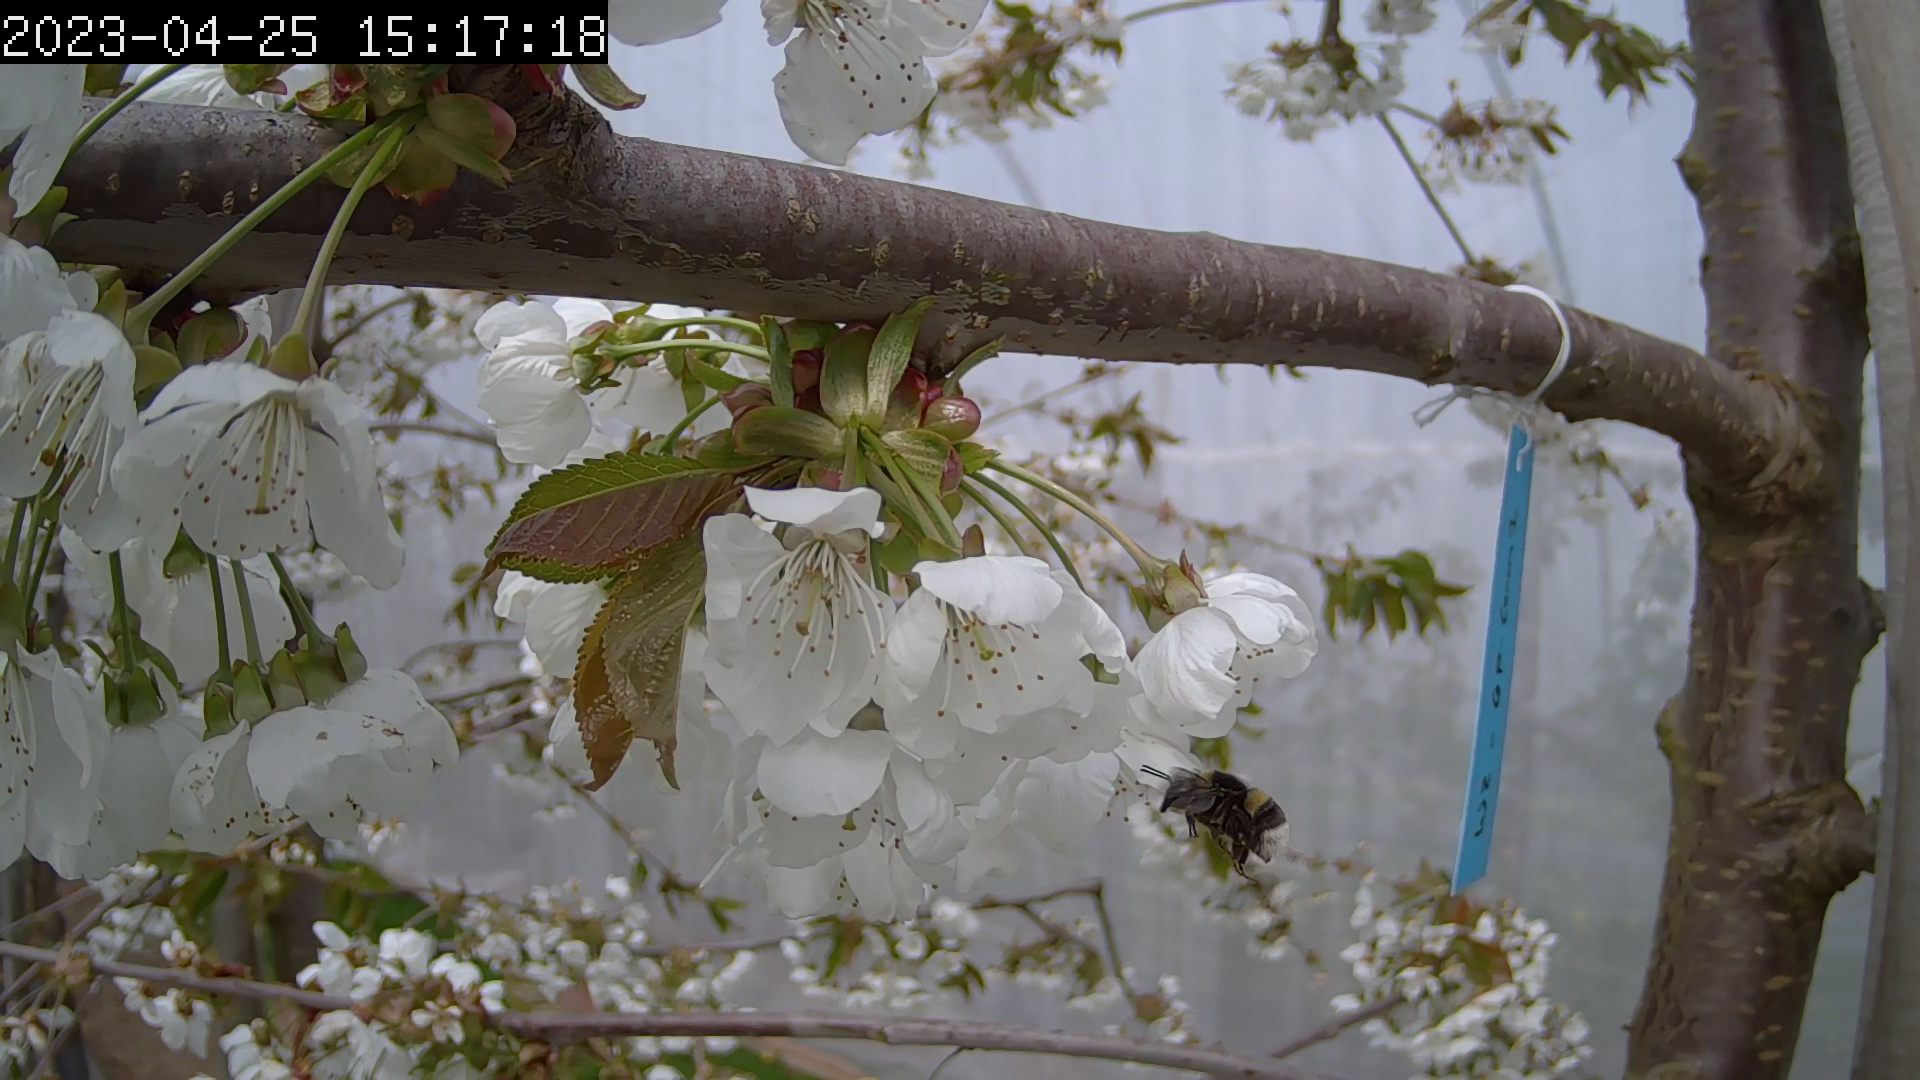

In [5]:
imagelist = os.listdir('/content/')
image = open('/content/bee6.jpg')
image = Image
image = open('/content/bee6.jpg')
image = Image.open('/content/bee6.jpg')
image

In [6]:
#declare some helper functions

#make sure text is in correct format
def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."


#colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

#plot some results
def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        label = f'{text}: {score:0.2f}'
        ax.text(xmin, ymin, label, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


In [7]:
processor = GroundingDinoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")

model = GroundingDinoForObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

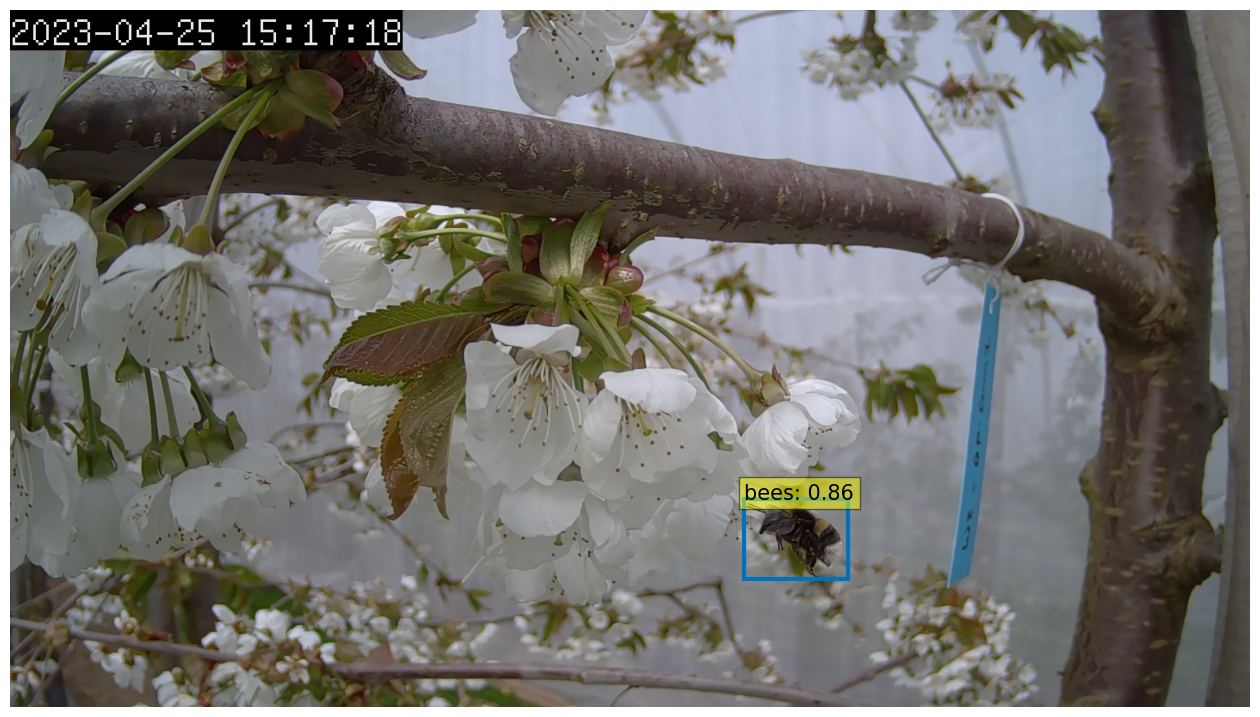

In [8]:
# text prompt for what you are looking for
text = "bees"

# process inputs
inputs = processor(images=image, text=preprocess_caption(text), return_tensors="pt")

# put inputs into model
with torch.no_grad():
    outputs = model(**inputs)

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.image_processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.14)
results = postprocessed_outputs[0]

plot_results(image, results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist())

In [9]:
results

{'scores': tensor([0.8639]),
 'labels': tensor([1]),
 'boxes': tensor([[1136.2595,  757.6235, 1296.3021,  881.1083]])}

In [10]:
import json
f = open('/content/bee6.1.json')
anno = json.load(f)
anno ['shapes']

[{'label': 'bee',
  'points': [[1130.1298701298701, 748.4415584415584],
   [1304.155844155844, 747.1428571428571],
   [1304.155844155844, 888.7012987012987],
   [1109.3506493506493, 882.2077922077922]],
  'group_id': None,
  'description': '',
  'shape_type': 'polygon',
  'flags': {},
  'mask': None}]

In [12]:
#getting the bounding boxes...
import numpy as np
box = np.array(anno['shapes'][0]['points'])
import torch

def get_boxesfromjson(fname):
    # open file
    f = open(fname)
    anno = json.load(f)
    f.close()

    # get just the shapes
    shapes = np.array(anno['shapes'])


    # create list of boxes
    boxes = []


    # loop through shapes
    for shape in shapes:
        # check in case i have other types of shapes i need to write code to support them
        if not shape['shape_type'] == 'polygon':
            print('we have a different shape type')
            print(shape['shape_type'])
            print('skipping..')
            continue

        # extract the points
        box_j = np.array(shape['points'])
        # define two corners to match grounding dino output
        topleft = box_j.min(axis=0)
        botright = box_j.max(axis=0)

        # turn into torch tensors and make list
        boxes.append(torch.Tensor([np.append(topleft,botright)]))

    return(boxes)

# get boxes from a json file change the filename to get different boxes
boxes_j = get_boxesfromjson('/content/' +'bee6.1.json')
boxgd= np.array(results['boxes'])
box

<ipython-input-12-a33ebc474332>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  boxes.append(torch.Tensor([np.append(topleft,botright)]))


array([[1130.12987013,  748.44155844],
       [1304.15584416,  747.14285714],
       [1304.15584416,  888.7012987 ],
       [1109.35064935,  882.20779221]])

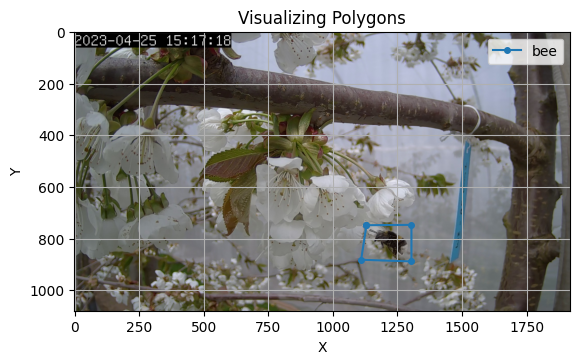

In [13]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_polygons(json_data):
    # Create a plot
    fig, ax = plt.subplots()

    # Plot each polygon
    for item in json_data:
        label = item['label']
        points = item['points']

        # Extract x and y coordinates
        x = [point[0] for point in points]
        y = [point[1] for point in points]

        # Plot polygon
        ax.plot(x + [x[0]], y + [y[0]], linestyle='-', marker='o', markersize=4, label=label)

    # Set plot labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Visualizing Polygons')
    ax.legend()

    # Show plot
    plt.grid(True)
    plt.imshow(image)
    plt.show()

# JSON data containing polygons
json_data = [
    {'label': 'bee', 'points': [[1130.12987013,  748.44155844],
                                [1304.15584416,  747.14285714],
                                [1304.15584416,  888.7012987 ],
                                [1109.35064935,  882.20779221]]}

]

visualize_polygons(json_data)
#this codes will visualize the bounding boxes of the json polygon

In [14]:
# calculate iintersection over union (how much the boxes overlap) bigger numbers better >0.5 is probably same bee detected well

# note this assumes we have two bees in image
import torchvision.ops.boxes as bops

iou = bops.box_iou(results['boxes'], boxes_j[0])
print(iou)

# delete following if just a single bee in image
#iou = bops.box_iou(results['boxes'], boxes_j[1])
#print(iou)
#the higher the overlap score the chances of being thesame bee. very low score would be they are not same. one high score tensor 0.5 means that the computer found thesame bee as me, but 0.0 means that the comupter couldnt find the bee i found/ labelled.

tensor([[0.7167]])


In [15]:
#the tensor (overlap) score is 0.72 (greater than 0.5) = 72% this means that this model detected thesame bee which i trained manually

now lets analyze the second image bees7.jpg

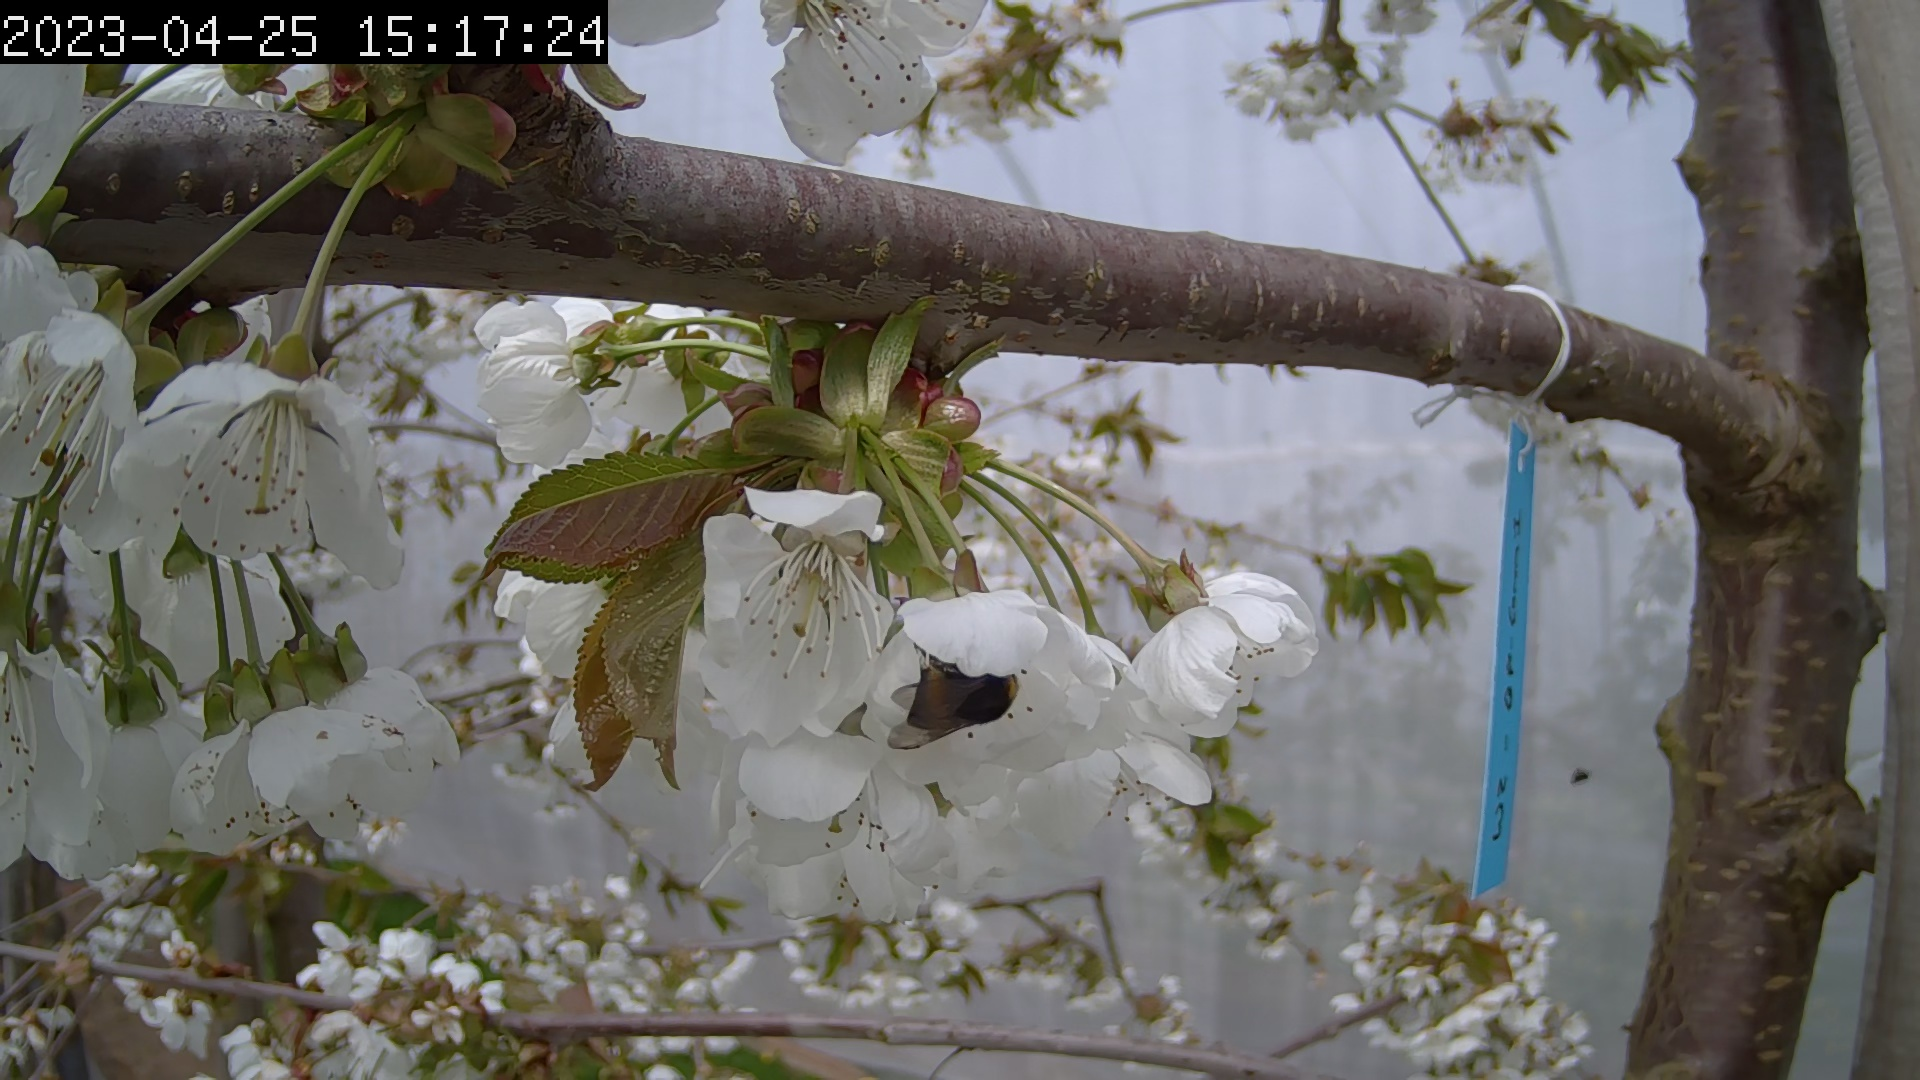

In [16]:
imagelist = os.listdir('/content/')
image = open('/content/bees7.jpg')
image = Image
image = open('/content/bees7.jpg')
image = Image.open('/content/bees7.jpg')
image

In [17]:
#declare some helper functions

#make sure text is in correct format
def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."


#colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

#plot some results
def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        label = f'{text}: {score:0.2f}'
        ax.text(xmin, ymin, label, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


In [18]:
processor = GroundingDinoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")

model = GroundingDinoForObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base")

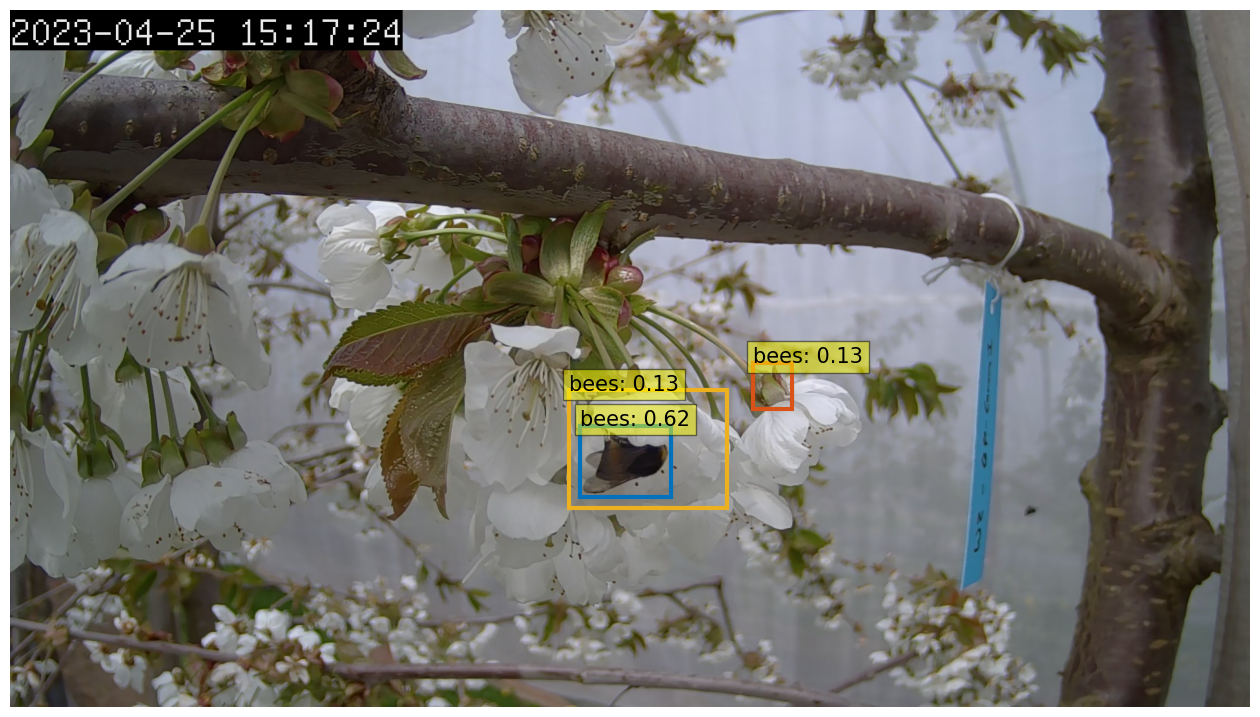

In [19]:
# text prompt for what you are looking for
text = "bees"

# process inputs
inputs = processor(images=image, text=preprocess_caption(text), return_tensors="pt")

# put inputs into model
with torch.no_grad():
    outputs = model(**inputs)

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.image_processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.13)
results = postprocessed_outputs[0]

plot_results(image, results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist())

In [20]:
results

{'scores': tensor([0.6244, 0.1338, 0.1326]),
 'labels': tensor([1, 1, 1]),
 'boxes': tensor([[ 882.4557,  644.1824, 1023.5497,  754.0654],
         [1150.1082,  546.7072, 1210.8914,  617.6812],
         [ 865.2385,  589.1002, 1110.0875,  770.7019]])}

In [21]:
#from this result 3 tensors were gotten but only one is above 0.5. now lets seehow many points were marked by importing the json equivalent bees7.1.json

In [22]:
import json
f = open('/content/bees7.1.json')
anno = json.load(f)
anno ['shapes']

[{'label': 'bee',
  'points': [[1552.2077922077922, 749.7402597402597],
   [1617.142857142857, 745.8441558441558],
   [1617.142857142857, 818.5714285714286],
   [1548.3116883116882, 805.5844155844156]],
  'group_id': None,
  'description': '',
  'shape_type': 'polygon',
  'flags': {},
  'mask': None},
 {'label': 'bee',
  'points': [[887.2727272727274, 618.5714285714286],
   [1036.6233766233765, 634.1558441558442],
   [1032.7272727272727, 786.1038961038961],
   [867.7922077922078, 758.8311688311688]],
  'group_id': None,
  'description': '',
  'shape_type': 'polygon',
  'flags': {},
  'mask': None}]

In [23]:
#two polygon points were trained, we will get the bounding boxes and visualize then go ahead to get the overlap score(s)

In [25]:
#getting the bounding boxes...
import numpy as np
box = np.array(anno['shapes'][0]['points'])
box1 = np.array(anno['shapes'][1]['points'])
import torch

def get_boxesfromjson(fname):
    # open file
    f = open(fname)
    anno = json.load(f)
    f.close()

    # get just the shapes
    shapes = np.array(anno['shapes'])


    # create list of boxes
    boxes = []


    # loop through shapes
    for shape in shapes:
        # check in case i have other types of shapes i need to write code to support them
        if not shape['shape_type'] == 'polygon':
            print('we have a different shape type')
            print(shape['shape_type'])
            print('skipping..')
            continue

        # extract the points
        box_j = np.array(shape['points'])
        # define two corners to match grounding dino output
        topleft = box_j.min(axis=0)
        botright = box_j.max(axis=0)

        # turn into torch tensors and make list
        boxes.append(torch.Tensor([np.append(topleft,botright)]))

    return(boxes)

# get boxes from a json file change the filename to get different boxes
boxes_j = get_boxesfromjson('/content/' +'bees7.1.json')
boxgd= np.array(results['boxes'])
box

array([[1552.20779221,  749.74025974],
       [1617.14285714,  745.84415584],
       [1617.14285714,  818.57142857],
       [1548.31168831,  805.58441558]])

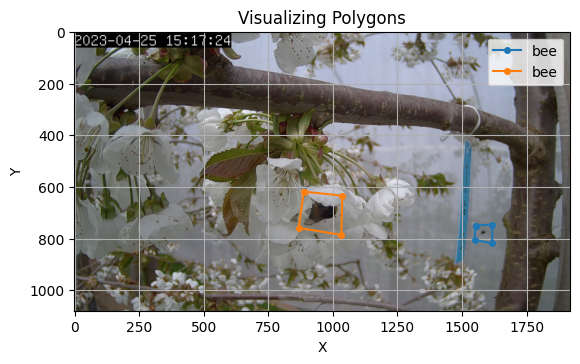

In [26]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_polygons(json_data):
    # Create a plot
    fig, ax = plt.subplots()

    # Plot each polygon
    for item in json_data:
        label = item['label']
        points = item['points']

        # Extract x and y coordinates
        x = [point[0] for point in points]
        y = [point[1] for point in points]

        # Plot polygon
        ax.plot(x + [x[0]], y + [y[0]], linestyle='-', marker='o', markersize=4, label=label)

    # Set plot labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Visualizing Polygons')
    ax.legend()

    # Show plot
    plt.grid(True)
    plt.imshow(image)
    plt.show()

# JSON data containing polygons
json_data = [
    {'label': 'bee', 'points': [[1552.20779221,  749.74025974],
                                [1617.14285714,  745.84415584],
                                [1617.14285714,  818.57142857],
                                [1548.31168831,  805.58441558]],},
    {'label': 'bee', 'points': ([[887.2727272727274, 618.5714285714286],
                                [1036.6233766233765, 634.1558441558442],
                                [1032.7272727272727, 786.1038961038961],
                                [867.7922077922078, 758.8311688311688]])}

]

visualize_polygons(json_data)
#this codes will visualize the bounding boxes of the json polygon

In [27]:
# calculate iintersection over union (how much the boxes overlap) bigger numbers better >0.5 is probably same bee detected well

# note this assumes we have two bees in image
import torchvision.ops.boxes as bops

iou = bops.box_iou(results['boxes'], boxes_j[0])
print(iou)

# delete following if just a single bee in image
iou = bops.box_iou(results['boxes'], boxes_j[1])
print(iou)
#the higher the overlap score the chances of being thesame bee. very low score would be they are not same. one high score tensor 0.5 means that the computer found thesame bee as me, but 0.0 means that the comupter couldnt find the bee i found/ labelled.

tensor([[0.],
        [0.],
        [0.]])
tensor([[0.5481],
        [0.0000],
        [0.5457]])
